__1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с горизонт прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" . Учитывать только глубину истории при p=3__

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor as GBR

In [2]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


def get_data_with_history(data, p=1, target='data'):
    for depth in range(1, p+1):
        data[f't_{depth}'] = np.concatenate((np.zeros((depth)), data[target].values))[:-depth]
    return data


def split_data_proportion(data, part=1, need_split_date=False):
    split_date = data.index[round(data.shape[0] * part)]
    train = data.loc[data.index <= split_date].copy()
    test = data.loc[data.index >  split_date].copy()
    
    if need_split_date: 
        return train, test, str(split_date)
    else:
        return train, test


def x_y_split_ts_with_horizon(train, test, target='data', h=0):
    
    X_train = train.iloc[:-h,:]
    y_train = train[target].values[h:]
    X_test = test.iloc[:-h,:]
    y_test = test[target].values[h:]
    
    return X_train, y_train, X_test, y_test


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def get_model_and_plot(h=1):
    plt.figure(figsize=(20, 4))
    plt.xlabel('Дата')
    plt.ylabel('MW')
    plt.plot(data[split_date:]['PJME_MW'].index, data[split_date:]['PJME_MW'].values, label='исходный ряд')
    plt.plot(test.index[h:], y_test, label='test data')
    plt.plot(test.index[h:], X_test_pred_gb, label='predict GB data')
    plt.legend()
    plt.show()
    er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)
    print(f'Ошибка градиентного бустинга :  {er_g:2f} %')

In [3]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [4]:
data = pd.DataFrame(data=df['PJME_MW'].values, index=pd.to_datetime(pd.DataFrame({'year': df.index.year,
                                                                                  'month': df.index.month,
                                                                                  'day': df.index.day,
                                                                                  'hour': df['hour'].values})).values, 
                    columns=['PJME_MW'])

data = data.resample('D').mean()
data['exp_1'] = exponential_smoothing(data['PJME_MW'], 0.01)
data = get_data_with_history(data, p=3, target='PJME_MW')
# data['diff'] = data['PJME_MW'].diff().values
data.head()

,PJME_MW,exp_1,t_1,t_2,t_3
2002-01-01,31080.739130,31080.739130,0.000000,0.000000,0.000000
2002-01-02,34261.541667,31112.547156,31080.739130,0.000000,0.000000
2002-01-03,34511.875000,31146.540434,34261.541667,31080.739130,0.000000
2002-01-04,33715.458333,31172.229613,34511.875000,34261.541667,31080.739130
2002-01-05,30405.125000,31164.558567,33715.458333,34511.875000,34261.541667


In [5]:
train, test, split_date = split_data_proportion(data, part=0.9, need_split_date=True)
X_train, y_train, X_test, y_test = x_y_split_ts_with_horizon(train, test, target='exp_1', h=1)

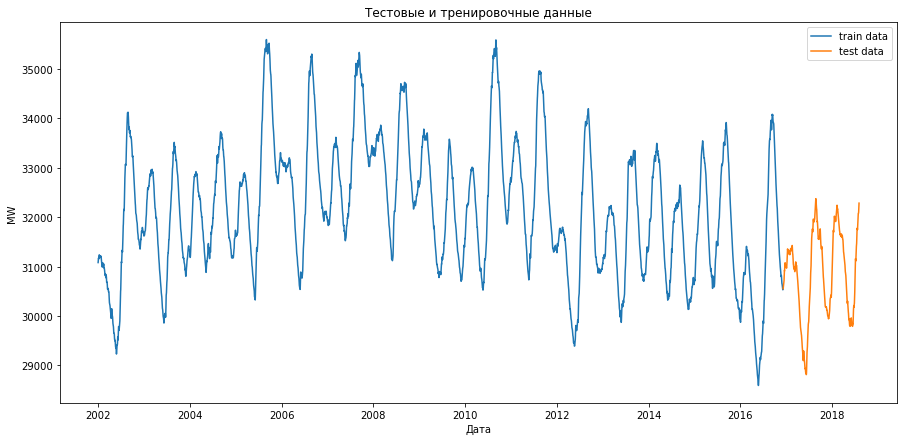

In [6]:
plt.figure(figsize=(15, 7))
plt.xlabel('Дата')
plt.ylabel('MW')
plt.plot(train.index,train['exp_1'], label='train data')
plt.plot(test.index, test['exp_1'], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

In [7]:
# обучим модель только по 2 параметрам 'exp_1' и 't_2'
model_gb = GBR(max_depth=15, random_state=21, n_estimators=100)
model_gb.fit(X_train.drop(columns=['PJME_MW']), y_train)

X_test_pred_gb = model_gb.predict(X_test.drop(columns=['PJME_MW']))

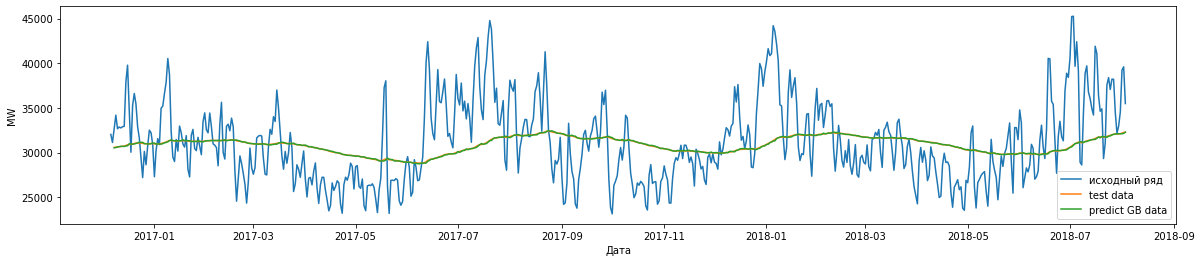

Ошибка градиентного бустинга :  0.119831 %


In [8]:
get_model_and_plot(h=1)

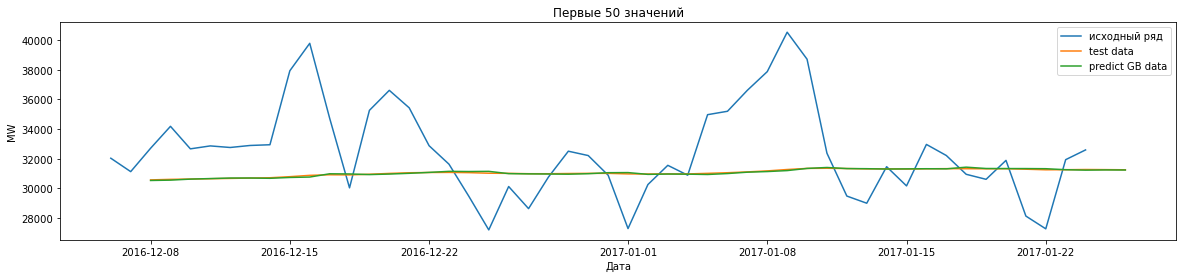

In [9]:
n_samples = 50
h = 1

plt.figure(figsize=(20, 4))

plt.xlabel('Дата')
plt.ylabel('MW')
plt.plot(data[split_date:]['PJME_MW'].index[:n_samples], data[split_date:]['PJME_MW'].values[:n_samples], label='исходный ряд')
plt.plot(test.index[h:][:n_samples], y_test[:n_samples], label='test data')
plt.plot(test.index[h:][:n_samples], X_test_pred_gb[:n_samples], label='predict GB data')
plt.title(f'Первые {n_samples} значений')

plt.legend()
plt.show()

__2. Оцените ошибку модели из п.1__

Ошибка градиентного бустинга считается относительно экспоненциально сглаженных значений, и эта ошибка крайне мала.

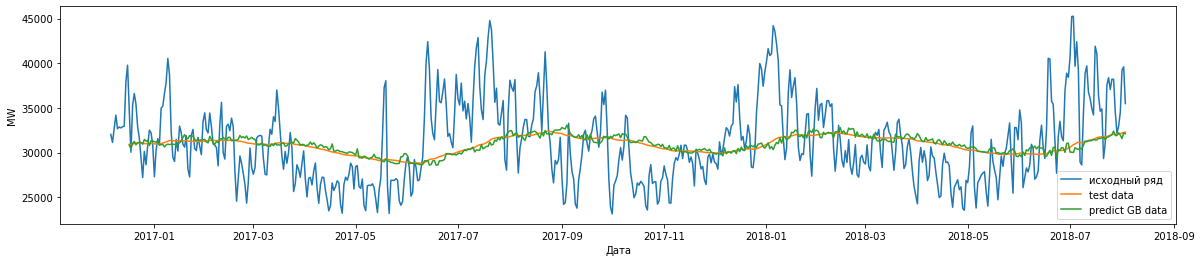

Ошибка градиентного бустинга :  0.922056 %


In [10]:
h = 10

X_train, y_train, X_test, y_test = x_y_split_ts_with_horizon(train, test, target='exp_1', h=h)

model_gb = GBR(max_depth=15, random_state=21, n_estimators=100)
model_gb.fit(X_train.drop(columns=['PJME_MW']), y_train)

X_test_pred_gb = model_gb.predict(X_test.drop(columns=['PJME_MW']))

get_model_and_plot(h=h)

__3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.__

Ошибка увеличилась, примерно, в 10 раз, относительно h = 1, она быстро растет даже при малом увеличении горизонта прогноза. Ошибка численно мала (около 1 %), что вызвано большим объемом данных.

__4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):__

а) Изменение температуры за окном :).

б) Количество денег, которые тратят покупатели в интернет магазине.

в) Вес растущего котенка.

г) Прирост объема деревьев в лесу от времени

а) Не стационарный, есть и сезоны (времена года), и циклы (аномально жаркие/холодные дни за n-лет), и тренд (глобальное потепление).

б) Не стационарный, т.к. траты в интернет-магазинах зависят от сезонности и праздников (черные пятницы и т.д.), а также есть прирост/отток покупателей.

в) Вес будет расти, значит мат.ожидание будет увеличиваться, значит ряд не стационарный.

г) Не, стационарный, есть тренд и сезонность.

__5. Какие из рядов на картинке стационарны на первый взгляд? (презентация, слайд номер 21)__

b и g